In [63]:
!pip install torch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Testing User Recommendation matrix

In this step dataset preprocessed in previous step is loaded and simple baseline model is tested.

Each line in a dataset contains data about one user and his final action on the offer. 
Either offer has been ignored, viewed or completed (offer proved to be interesting to a customer).

In [39]:
df = pd.read_csv('./userdata.csv')

In [40]:
df.head()

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
0,0,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,0,1372,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
1,2,68,e2127556f4f64592b11af22de27a7932,20180426,4,934,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
2,0,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,0,1147,1.0,462.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
3,0,118,68617ca6246f4fbc85e91a2a49552598,20171002,0,1140,1.0,432.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
4,2,65,389bc3fa690240e798340f5a15918d5c,20180209,3,1010,2.0,498.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0


In [41]:
print("Dataset contains %s actions:" % len(df))

Dataset contains 72628 actions:


### Let's plot the actions for one user

From the output can be seen that user completed an offer `0b1e...` and viewed `ae26...`. Offer `2906..` had been ignored twice.

In [42]:

df[df.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,gender,age,id,became_member_on,income,memberdays,event,time,offer_id,reward,difficulty,duration,web,email,mobile,social,bogo,discount,informational
5,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,2467,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
6,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,2467,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,1,0,0,1,0
7146,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,2467,2.0,456.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,1,0,0,0,1,0
50876,2,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,2,2467,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,0,1,1,1,1,0,0


### Preparing data for training
Let's create user-offer matrix by encoding each id into categorical value.

In [43]:
def to_categorical(df, columns):
    for col in columns:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes
    return df

In [38]:
x = pd.Categorical(df['offer_id'])
x.cat.codes

AttributeError: 'Categorical' object has no attribute 'cat'

In [44]:
df = to_categorical(df, ['id', 'offer_id', 'event'])
df.dtypes

gender                int64
age                   int64
id                    int16
became_member_on      int64
income                int64
memberdays            int64
event                  int8
time                float64
offer_id               int8
reward                int64
difficulty            int64
duration              int64
web                   int64
email                 int64
mobile                int64
social                int64
bogo                  int64
discount              int64
informational         int64
dtype: object

Recommendation matrix is very similar to embeddings. So we will leverage this and will train embedding along the model.

In [45]:
# Set embedding sizes
N = len(df['id'].unique())
M = len(df['offer_id'].unique())

# Set embedding dimension
D = 20

In [46]:
offer_specs = ['difficulty', 'duration', 'reward', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'became_member_on', 'gender', 'income', 'memberdays']

In [254]:
# Create a neural network that takes additional continuous paramets
class Model(nn.Module):
    def __init__(self, n_users, n_items, n_cont_user, n_cont_offer, embed_dim, output_dim, layers=[1024], p=0.4, batch_size = 8):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        self.bn_cont_u = nn.BatchNorm1d(n_cont_user)
        self.bn_cont_o = nn.BatchNorm1d(n_cont_offer)
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        
        layerlist = []
        n_in = 2 * self.D + n_cont_user + n_cont_offer
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            layerlist.append(nn.ReLU())
            n_in = i
        layerlist.append(nn.Linear(layers[-1],output_dim))
        self.layers = nn.Sequential(*layerlist)
        
        nn.init.xavier_uniform_(self.layers[0].weight)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.xavier_uniform_(self.layers[-1].weight)
        nn.init.zeros_(self.layers[-1].bias)

    def forward(self, user, offer, user_details, offer_details):
        u = self.u_emb(user) # output is (num_samples, D)
        m = self.m_emb(offer) # output is (num_samples, D)

        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)
        u_cont = self.bn_cont_u(user_details)
        o_cont = self.bn_cont_o(offer_details)
        out = torch.cat([out, u_cont, o_cont], 1)
        x1 = self.layers(out)
        loss = 0
        x2 = torch.zeros(batch_size)
        x3 = torch.zeros(batch_size)
        
        for i in range(batch_size):
            for user_2 in neighbourhood_usr[user[i].item()]:
                user_2 = int(user_2)
                user_2 = torch.tensor(user_2).to(device)
                u_second = self.u_emb(user_2)
                x2[i] =torch.sigmoid(torch.dot(u_second,u[i]))
        
            for item_2 in neighbourhood_item[offer[i].item()]:
                item_2 = int(item_2)
                i_second = self.m_emb(torch.tensor(item_2).to(device)).squeeze()
                x3[i] = torch.sigmoid(torch.dot(i_second,m[i]))
            
        return x1,x2.to(device),x3.to(device)

In [255]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

layers = [1024, 1024, 512, 256, 128]
model = Model(N, M, 
              n_cont_user=df[user_specs].shape[1], 
              n_cont_offer=df[offer_specs].shape[1],
              embed_dim=D, 
              output_dim=df['event'].nunique(), 
              layers=layers)
model.to(device)

# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.BCELoss()
criterion3 = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0.9)

cuda:0


In [256]:
model

Model(
  (bn_cont_u): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cont_o): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (u_emb): Embedding(16994, 20)
  (m_emb): Embedding(10, 20)
  (layers): Sequential(
    (0): Linear(in_features=55, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

## Creating User to Item and Item to User Dictionaries

In [80]:
import time

u2i = {}
i2u = {}

start = time.time()
for user in list(df.id.unique()):
    df_user = df[df['id']==user]
    u2i[user] = [i for i in df_user.offer_id.unique()]
end = time.time()
print("The time taken to Create U2I Dictionary:",round(end-start,2),"secs")

for offer in list(df.offer_id.unique()):
    df_offer = df[df['offer_id']==offer]
    i2u[offer] = [i for i in df_offer.id.unique()]
    print("Users for Item",offer,"=",len(i2u[offer]))

The time taken to Create U2I Dictionary: 22.49 secs
Users for Item 2 = 6285
Users for Item 0 = 6374
Users for Item 9 = 6332
Users for Item 1 = 6325
Users for Item 6 = 6355
Users for Item 3 = 6331
Users for Item 5 = 6320
Users for Item 7 = 6374
Users for Item 8 = 6262
Users for Item 4 = 6330


In [211]:
from collections import Counter

neighbourhood_usr = {}
start = time.time()
nbrhood_threshold = 3
for user in list(df.id.unique()):
    neighbour = []
    
    for item in u2i[user]:
        neighbour.extend(i2u[item])
        
    count = Counter(neighbour)
    usr_nbr = []
    for user2 in count.keys():
        if count[user2] > nbrhood_threshold and user2 != user:
            usr_nbr.append(user2)
    
    neighbourhood_usr[user] = usr_nbr
    
end = time.time()
print("Time Taken:",round(end-start,2),"Seconds")

Time Taken: 104.24 Seconds


In [212]:
neighbourhood_item = {}
nbrhood_threshold = 2100
for item in list(df.offer_id.unique()):
    neighbour = []
    
    for user in i2u[item]:
        neighbour.extend(u2i[user])
    
    count = Counter(neighbour)
    
    itm_nbr = []
    for item2 in count.keys():
        if count[item2] > nbrhood_threshold and item2 != item:
            itm_nbr.append(item2)
            
    neighbourhood_item[item] = itm_nbr

In [213]:
lengths1 = [len(i) for i in neighbourhood_usr.values()]
#print(lengths1)
print(np.mean(lengths1))
print(np.std(lengths1))


lengths2 = [len(i) for i in neighbourhood_item.values()]
print(np.mean(lengths2))
print(lengths2)

205.68753677768623
306.90634611459546
4.8
[4, 5, 5, 4, 5, 5, 5, 7, 3, 5]


### Create additional user and offer details tensors

In [144]:
offer_ids_t = np.array([int(i) for i in df['offer_id'].values])
ratings_t = np.array([int(i) for i in df['event'].values])

In [145]:
# Convert to tensors
# Make datasets
# We name events as rating for give better insight on the target value
# and ease of comparison to other similar models

user_ids_t = torch.from_numpy((df['id'].values)).long()
offer_ids_t = torch.from_numpy(offer_ids_t).long()
ratings_t = torch.from_numpy(ratings_t).long()

user_params_t = torch.from_numpy(df[user_specs].values).float()
offer_params_t = torch.from_numpy(df[offer_specs].values).float()

In [147]:
import torch.utils.data

In [231]:
# Make datasets
N_train = int(0.8 * len(df['event'].values))
N_test = 1000
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:N_train],
    offer_ids_t[:N_train],
    user_params_t[:N_train],
    offer_params_t[:N_train],
    ratings_t[:N_train],
)

val_dataset = torch.utils.data.TensorDataset(
    user_ids_t[N_train:-N_test],
    offer_ids_t[N_train:-N_test],
    user_params_t[N_train:-N_test],
    offer_params_t[N_train:-N_test],
    ratings_t[N_train:-N_test],
    
)
test_df = df[-N_test:]

In [232]:
# Data loaders
batch_size = 8
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [263]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    acc_list = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for users, offers, u_params, o_params, targets in train_loader:
            

            # move data to GPU
            targets_item = torch.tensor([1.0]*batch_size)
            targets_user = torch.tensor([1.0]*batch_size)
            
            users, offers, u_params, o_params, targets,targets_item,targets_user = users.to(device), offers.to(device),  u_params.to(device), o_params.to(device), targets.to(device), targets_item.to(device),targets_user.to(device)
            #targets = targets.view(-1, 1).long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs1, outputs2, outputs3 = model(users, offers, u_params, o_params)
            
            loss1 = criterion1(outputs1, targets.squeeze())
            loss2 = criterion2(outputs2, targets_user.squeeze())
            loss3 = criterion3(outputs3, targets_item.squeeze())
            
            loss = loss1 + loss2 + loss3

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
            # Track the accuracy
            total = targets.size(0)
            _, predicted = torch.max(outputs1.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / total
            acc_list.append(acc)

        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        
        val_loss = []
        
        # validation
        with torch.no_grad():
            model.eval()
            
            for users, offers, u_params, o_params, targets in validation_loader:
                users, offers, u_params, o_params, targets,targets,targets_item,targets_user = users.to(device), offers.to(device),  u_params.to(device), o_params.to(device), targets.to(device), targets_item.to(device),targets_user.to(device)
                #targets = targets.view(-1, 1).long()
                outputs1, outputs2, outputs3 = model(users, offers, u_params, o_params)
                loss1 = criterion1(outputs1, targets.squeeze())
                loss2 = criterion2(outputs2, targets_user.squeeze())
                loss3 = criterion3(outputs3, targets_item.squeeze())
            
                loss = loss1 + loss2 + loss3
                val_loss.append(loss.item())
        
        val_loss = np.mean(val_loss)
        # Save losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Validations Loss: {val_loss:.4f}, Accuracy: {acc:.4f}, Duration: {dt}')

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = batch_gd( \
    model, criterion, optimizer, train_loader, validation_loader, 5)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='test loss')
plt.legend()
plt.show()

In [31]:
start_ix = 0
end_ix = -1
test_X =  torch.from_numpy(test_df.iloc[start_ix:end_ix]['id'].values).long()
test_y = torch.from_numpy(test_df.iloc[start_ix:end_ix]['event'].values).long()
user_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][user_specs].values).float()
offer_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][offer_specs].values).float()

with torch.no_grad():
    
    model.eval()
    pred = model(test_X.to(device), test_y.to(device), user_params_t.to(device), offer_params_t.to(device))
    #print(pred)
_, predicted = torch.max(pred.data, 1)
#print(predicted)

In [32]:
from sklearn.metrics import confusion_matrix,  accuracy_score
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save=False,
                          figname='cm.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
        plt.savefig(figname, dpi=fig.dpi)
    plt.show()

#### Plot confusion matrix and baseline accuracy

Confusion matrix, without normalization
[[  6   1   7]
 [  0 275 252]
 [ 49  38 371]]


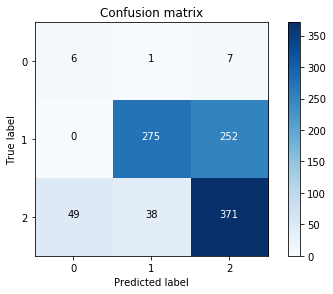

In [33]:
# Tensors should be copied back to cpu using tensor.cpu()
test_y = test_y.cpu()
predicted = predicted.cpu()
cm = confusion_matrix(test_y, predicted)
classes = [0,1,2]
plot_confusion_matrix(cm, classes, save=True, figname='./images/RecommendationEngine-cm.png')

In [34]:
print("Accuracy so far: " + str(100*accuracy_score(test_y, predicted))+ "%" )

Accuracy so far: 65.26526526526526%


Results are decent so far and almost twice better than random quessing.

#### Show some predicted examples

In [35]:
start_ix = 10
end_ix = 30
data = test_df.iloc[start_ix:end_ix][['age', 'became_member_on', 'gender', 'id', 'income', 'memberdays', 'event']]#['offer_id'].values
pred_values = pd.DataFrame(predicted[start_ix:end_ix], columns=['predicted'], index=data.index)
results = pd.concat([data, pred_values], axis=1)
results

,age,became_member_on,gender,id,income,memberdays,event,predicted
71638,42,20170806,2,11854,4,987,2,2
71639,118,20150829,0,6712,0,1695,1,1
71640,118,20150829,0,6712,0,1695,1,1
71641,47,20180427,3,5350,3,723,1,2
71642,70,20160325,3,6908,3,1486,2,2
71643,59,20160815,2,14044,6,1343,2,2
71644,49,20171110,2,11158,5,891,2,2
71645,73,20170626,2,3378,2,1028,2,2
71646,41,20161212,2,11261,1,1224,1,2
71647,49,20170428,2,9752,4,1087,1,2


From the output we see that for randomly selected 10 users model was inaccurate twice, but was able to predict user positive actions on offer.

Mislassifications:

In [36]:
results[results.event != results.predicted]

,age,became_member_on,gender,id,income,memberdays,event,predicted
71641,47,20180427,3,5350,3,723,1,2
71646,41,20161212,2,11261,1,1224,1,2
71647,49,20170428,2,9752,4,1087,1,2
71649,73,20170808,2,16467,2,985,1,2
71650,73,20170808,2,16467,2,985,1,2
71653,26,20161029,2,14754,4,1268,1,2
71655,18,20180613,2,12373,3,676,1,2
71657,54,20170425,3,8072,7,1090,2,0


Now let's save the model for future reference

In [37]:
#!mkdir model
import os

def save_model(model, model_name, model_info):
    # Save the parameters used to construct the model
    with open(model_name, 'wb') as f:
        torch.save(model_info, f)

    # Save the model parameters
    
    with open(model_name, 'wb') as f:
        torch.save(model.cpu().state_dict(), f)

model_info = {    
          'n_users': M, 
          'n_items': N, 
          'n_cont_user': df[user_specs].shape[1], 
          'n_cont_offer': df[offer_specs].shape[1],
          'embed_dim': D, 
          'output_dim': df['event'].nunique(), 
          'layers': layers, 
          'p': 0.4
    }
save_model(model, './model/RecommendationModel2.pth', model_info)

Let's additionally check another metrics for the model

In [40]:
layers = [1024, 1024, 512, 256, 128]
model = Model(N, M, 
              n_cont_user=df[user_specs].shape[1], 
              n_cont_offer=df[offer_specs].shape[1],
              embed_dim=D, 
              output_dim=df['event'].nunique(), 
              layers=layers)

model2.load_state_dict(torch.load('./model/RecommendationModel2.pth'));
model2.to(device).eval()

Model(
  (bn_cont_u): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cont_o): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (u_emb): Embedding(16994, 20)
  (m_emb): Embedding(10, 20)
  (layers): Sequential(
    (0): Linear(in_features=55, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, e

In [41]:
start_ix = 0
end_ix = -1
test_X =  torch.from_numpy(test_df.iloc[start_ix:end_ix]['id'].values).long()
test_y = torch.from_numpy(test_df.iloc[start_ix:end_ix]['event'].values).long()
user_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][user_specs].values).float()
offer_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][offer_specs].values).float()

with torch.no_grad():
    model2.eval()
    pred = model2(test_X.to(device), test_y.to(device), user_params_t.to(device), offer_params_t.to(device))
    #print(pred)
_, predicted = torch.max(pred.data, 1)
#print(predicted)

Confusion matrix, without normalization
[[  6   1   7]
 [  0 275 252]
 [ 49  38 371]]


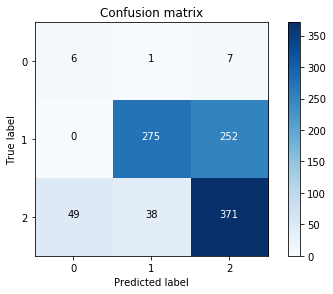

In [42]:
# Tensors should be copied back to cpu using tensor.cpu()
test_y = test_y.cpu()
predicted = predicted.cpu()
cm = confusion_matrix(test_y, predicted)
classes = [0,1,2]
plot_confusion_matrix(cm, classes)

In [43]:
print("Accuracy so far: " + str(100*accuracy_score(test_y, predicted))+ "%" )

Accuracy so far: 65.26526526526526%


In [44]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("F1 score for the model: " + str(f1_score(test_y, predicted, average='weighted')))
print("Recall score for the model: " + str(recall_score(test_y, predicted, average='weighted')))
print("Precision score for the model: " + str(precision_score(test_y, predicted, average='weighted')))

F1 score for the model: 0.6600933677929535
Recall score for the model: 0.6526526526526526
Precision score for the model: 0.7335164863119569
